# Forecasting commodity prices with generative adversarial networks

**Paper:** https://doi.org/10.1109/ACCESS.2019.2915544

Import the dependencies.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

2024-07-26 18:48:08.600589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Define a function for fixing the random seeds, for reproducibility.

In [2]:
def set_seeds(seed):
    '''
    Fix the random seeds.
    '''
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)


def set_global_determinism(seed):
    '''
    Fix all sources of randomness.
    '''
    set_seeds(seed=seed)

    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

Define the generator architecture.

In [3]:
class Generator(tf.keras.Model):
    '''
    Generator model.
    '''

    def __init__(self, units, noise_dimension):
        super().__init__()

        # recurrent layer
        self.rnn = tf.keras.layers.LSTM(units=units, return_sequences=False)

        # dense layer
        self.dense = tf.keras.layers.Dense(units=units + noise_dimension, activation="relu")

        # output layer
        self.out = tf.keras.layers.Dense(units=1)

    def call(self, inputs):

        # extract the inputs
        condition, noise = inputs

        # get the condition representation
        representation = self.rnn(condition)

        # extend the condition representation with the noise vector
        representation = tf.concat([representation, noise], axis=-1)

        # get the predicted value
        prediction = self.out(self.dense(representation))

        return prediction

Define the discriminator architecture.

In [4]:
class Discriminator(tf.keras.Model):
    '''
    Discriminator model.
    '''

    def __init__(self, units):
        super().__init__()

        # recurrent layer
        self.rnn = tf.keras.layers.LSTM(units=units, return_sequences=False)

        # output layer
        self.out = tf.keras.layers.Dense(units=1, activation="sigmoid")

    def call(self, inputs):

        # extract the inputs
        condition, next_value = inputs

        # extend the condition with the next value (either actual/real or predicted/fake)
        condition = tf.concat([condition, tf.expand_dims(next_value, axis=1)], axis=1)

        # get the condition representation
        representation = self.rnn(condition)

        # get the predicted probability
        probability = self.out(representation)

        return probability

Define a custom class for training the model and generating the distributional forecasts.

In [5]:
class ForGAN():
    '''
    ForGAN model.
    '''
    def __init__(self,
                 generator_units,
                 discriminator_units,
                 condition_length,
                 noise_dimension,
                 seed=42):

        self.generator_units = generator_units
        self.discriminator_units = discriminator_units
        self.condition_length = condition_length
        self.noise_dimension = noise_dimension
        self.seed = seed

    def fit(self, x, learning_rate, batch_size, epochs):

        # fix the random seeds
        set_global_determinism(seed=self.seed)

        # scale the time series
        x = x.copy().values
        self.mu = np.mean(x, axis=0)
        self.sigma = np.std(x, axis=0, ddof=1)
        x = (x - self.mu) / self.sigma
        
        # split the time series into condition sequences and target values
        condition = []
        target = []
        for t in range(self.condition_length, len(x)):
            condition.append(x[t - self.condition_length: t, :])
            target.append(x[t, :])
        condition = np.array(condition)
        target = np.array(target)

        # split the condition sequences and target values into batches
        dataset = tf.data.Dataset.from_tensor_slices((tf.cast(condition, tf.float32), tf.cast(target, tf.float32)))
        dataset = dataset.cache().shuffle(buffer_size=len(target), seed=self.seed).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        # build the models
        self.generator_model = Generator(units=self.generator_units, noise_dimension=self.noise_dimension)
        self.discriminator_model = Discriminator(units=self.discriminator_units)

        # instantiate the optimizers
        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        # define the loss functions
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

        # define the training loop
        @tf.function
        def train_step(data):
            with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:

                # extract the condition sequences and the target values
                condition, target = data

                # generate the noise vector
                noise = tf.random.normal(shape=(len(condition), self.noise_dimension))

                # generate the target values
                prediction = self.generator_model(inputs=[condition, noise])

                # pass the actual and the generated target values to the discriminator
                target_probability = self.discriminator_model(inputs=[condition, target])
                prediction_probability = self.discriminator_model(inputs=[condition, prediction])

                # calculate the generator loss
                generator_loss = bce(y_true=tf.ones_like(prediction_probability), y_pred=prediction_probability)

                # calculate the discriminator loss
                discriminator_loss = bce(y_true=tf.ones_like(target_probability), y_pred=target_probability) + \
                                     bce(y_true=tf.zeros_like(prediction_probability), y_pred=prediction_probability)

            # calculate the gradients
            generator_gradients = generator_tape.gradient(generator_loss, self.generator_model.trainable_variables)
            discriminator_gradients = discriminator_tape.gradient(discriminator_loss, self.discriminator_model.trainable_variables)

            # update the weights
            generator_optimizer.apply_gradients(zip(generator_gradients, self.generator_model.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator_model.trainable_variables))

            return generator_loss, discriminator_loss

        # train the models
        pbar = tqdm(range(epochs))
        for epoch in pbar:
            for data in dataset:
                generator_loss, discriminator_loss = train_step(data)
            pbar.set_description_str("Epoch: {}  Generator Loss: {:.4f}  Discriminator Loss: {:.4f}".format(1 + epoch, generator_loss, discriminator_loss))

    def predict(self, x, samples):

        # fix the random seeds
        set_global_determinism(seed=self.seed)

        # scale the time series
        x = x.copy().values
        x = (x - self.mu) / self.sigma

        # get the condition sequence
        condition = np.expand_dims(x[- self.condition_length:], axis=0)

        # generate the next value of the target time series
        simulation = []
        
        # loop across the number of samples to be generated
        for sample in range(samples):

            # generate the noise vector
            noise = tf.random.normal(shape=(len(condition), self.noise_dimension))

            # generate the next target value
            prediction = self.generator_model(inputs=[condition, noise]).numpy()

            # transform the generated target values back to the original scale
            prediction = self.mu + self.sigma * prediction

            # save the generated target values
            simulation.append(prediction)
        
        # cast the generated target values to array
        simulation = np.concatenate(simulation, axis=1)

        return simulation

Define the ticker to be predicted.

In [6]:
ticker = "^BCOM"

Define the size of the test set.

In [7]:
test_size = 30

Download the ticker time series from Yahoo! Finance.

In [8]:
dataset = yf.download(ticker, start="2022-07-27", end="2024-07-26")
dataset = dataset[["Close"]].rename(columns={"Close": ticker})

[*********************100%%**********************]  1 of 1 completed


In [9]:
dataset.shape

(502, 1)

In [10]:
dataset.head()

,^BCOM
Date,
2022-07-27,119.940002
2022-07-28,120.290001
2022-07-29,121.830002
2022-08-01,119.800003
2022-08-02,117.779999


In [11]:
dataset.tail()

,^BCOM
Date,
2024-07-19,97.489998
2024-07-22,98.089996
2024-07-23,97.489998
2024-07-24,97.300003
2024-07-25,96.779999


Fit the model to the training set.

In [12]:
model = ForGAN(
    generator_units=256,
    discriminator_units=64,
    condition_length=5,
    noise_dimension=10,
    seed=42
)

model.fit(
    x=dataset.iloc[:- test_size],
    learning_rate=0.001,
    batch_size=64,
    epochs=100,
)

Epoch: 100  Generator Loss: 0.6943  Discriminator Loss: 1.3864: 100%|█| 100/100 


Generate the one-step-ahead predictions over the test set.

In [13]:
simulations = []
for t in reversed(range(1, 1 + test_size)):
    simulations.append(model.predict(x=dataset.iloc[:- t], samples=100))
simulations = np.concatenate(simulations, axis=0)

In [14]:
simulations.shape

(30, 100)

Calculate the summary statistics of the one-step-ahead predictions.

In [15]:
predictions = pd.DataFrame(
    data={
        "actual": dataset.iloc[- test_size:].values.flatten(),
        "median": np.median(simulations, axis=1),
        "q005": np.quantile(simulations, 0.005, axis=1),
        "q995": np.quantile(simulations, 0.995, axis=1),
        "q10": np.quantile(simulations, 0.10, axis=1),
        "q90": np.quantile(simulations, 0.90, axis=1),
    },
    index=dataset.index[-test_size:]
)

In [16]:
predictions.shape

(30, 6)

In [17]:
predictions.head()

,actual,median,q005,q995,q10,q90
Date,,,,,,
2024-06-12,103.330002,101.976800,100.151833,103.193533,101.348286,102.733258
2024-06-13,102.779999,102.344561,100.529134,103.540816,101.730444,103.104710
2024-06-14,102.440002,102.314136,100.494566,103.510515,101.694686,103.071796
2024-06-17,101.910004,102.232727,100.414666,103.443185,101.605897,102.989648
2024-06-18,102.730003,101.936358,100.111711,103.170201,101.297357,102.691417


In [18]:
predictions.tail()

,actual,median,q005,q995,q10,q90
Date,,,,,,
2024-07-19,97.489998,98.937021,97.178786,100.046070,98.363017,99.764171
2024-07-22,98.089996,98.234778,96.508318,99.293759,97.677466,99.022057
2024-07-23,97.489998,97.967157,96.260514,98.995005,97.422956,98.719411
2024-07-24,97.300003,97.612033,95.925104,98.600906,97.083515,98.313843
2024-07-25,96.779999,97.342763,95.666485,98.299740,96.807994,98.003339


Calculate the performance metrics of the one-step-ahead predictions.

In [19]:
metrics = pd.DataFrame(
    columns=["Metric", "Value"],
    data=[
        {"Metric": "RMSE", "Value": format(root_mean_squared_error(y_true=predictions["actual"], y_pred=predictions["median"]), ".4f")},
        {"Metric": "MAE", "Value": format(mean_absolute_error(y_true=predictions["actual"], y_pred=predictions["median"]), ".4f")},
        {"Metric": "MAPE", "Value": format(mean_absolute_percentage_error(y_true=predictions["actual"], y_pred=predictions["median"]), ".2%")},
    ]
)

In [20]:
metrics

,Metric,Value
0,RMSE,0.6724
1,MAE,0.5406
2,MAPE,0.54%


Visualize the one-step-ahead predictions.

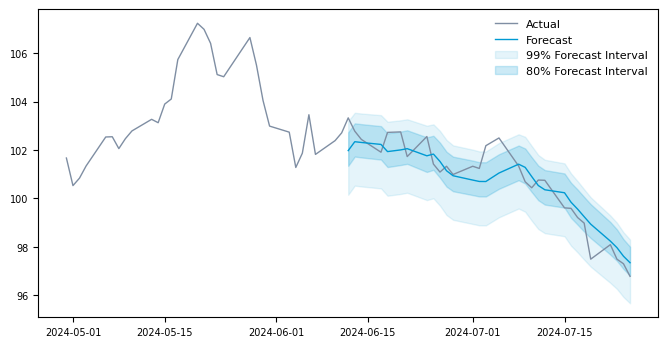

In [21]:
plt.subplots(figsize=(8, 4))
plt.plot(dataset.index[- 2 * test_size:], dataset.values[- 2 * test_size:], lw=1, color="#7f8ea3", label="Actual")
plt.plot(predictions.index, predictions["median"], lw=1, color="#009ad3", label="Forecast")
plt.fill_between(predictions.index, predictions["q005"], predictions["q995"], color="#009ad3", alpha=0.1, label="99% Forecast Interval")
plt.fill_between(predictions.index, predictions["q10"], predictions["q90"], color="#009ad3", alpha=0.2, label="80% Forecast Interval")
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(frameon=False, fontsize=8)
plt.show()